In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('store.csv').fillna(0)
# stock_data = stocks["Close"]
stock_data

,Unnamed: 0,DateTime,Open,High,Low,Close,Volume
0,0,2024-03-07 03:45:00,790.00,793.40,787.85,791.20,1066758
1,1,2024-03-07 03:50:00,791.50,793.20,790.35,790.60,574140
2,2,2024-03-07 03:55:00,790.50,791.20,789.40,790.45,366822
3,3,2024-03-07 04:00:00,790.45,792.25,789.35,790.70,439014
4,4,2024-03-07 04:05:00,790.70,790.70,789.05,789.20,294579
...,...,...,...,...,...,...,...
445,445,2024-03-15 09:35:00,732.15,733.70,730.45,731.85,1942156
446,446,2024-03-15 09:40:00,732.00,732.90,731.85,732.30,1508401
447,447,2024-03-15 09:45:00,732.35,732.50,731.75,732.45,1134023
448,448,2024-03-15 09:50:00,732.45,733.75,729.95,729.95,2197836


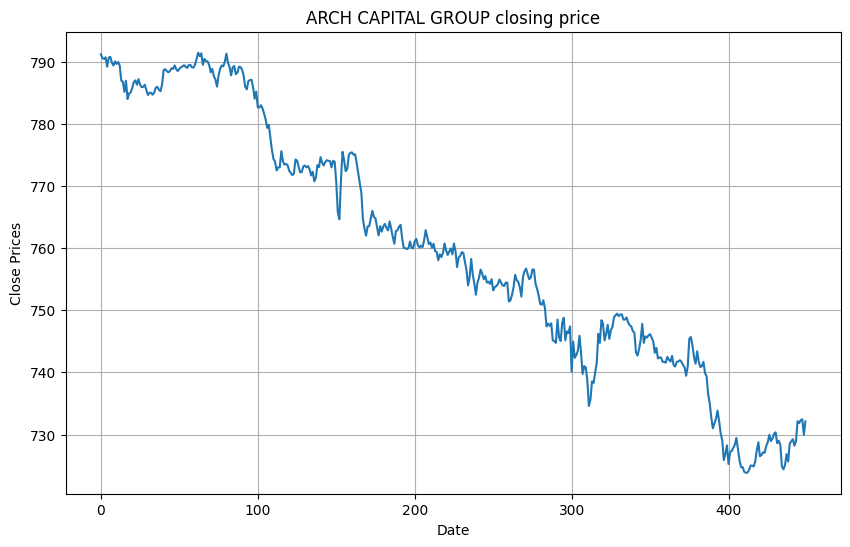

In [2]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

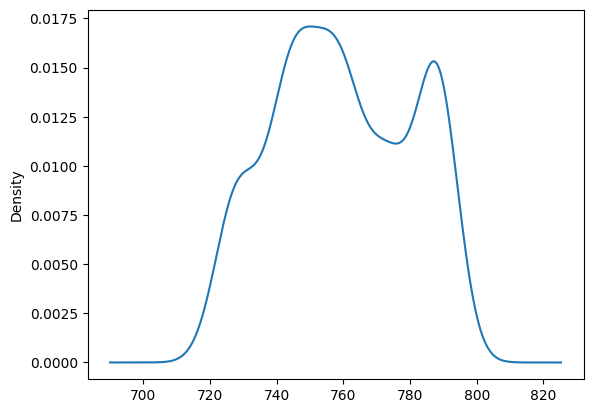

In [3]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

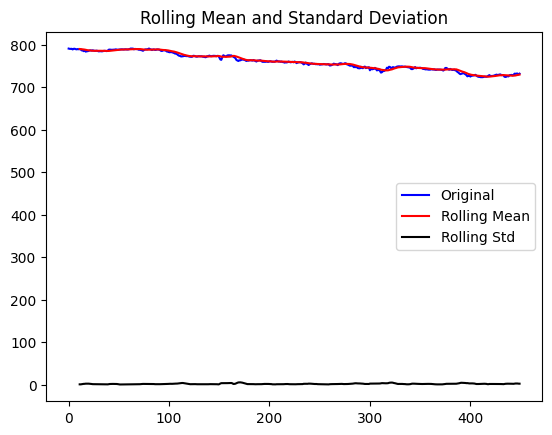

Results of dickey fuller test
Test Statistics                 -0.799747
p-value                          0.819196
No. of lags used                 3.000000
Number of observations used    446.000000
critical value (1%)             -3.445097
critical value (5%)             -2.868042
critical value (10%)            -2.570233
dtype: float64


In [4]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

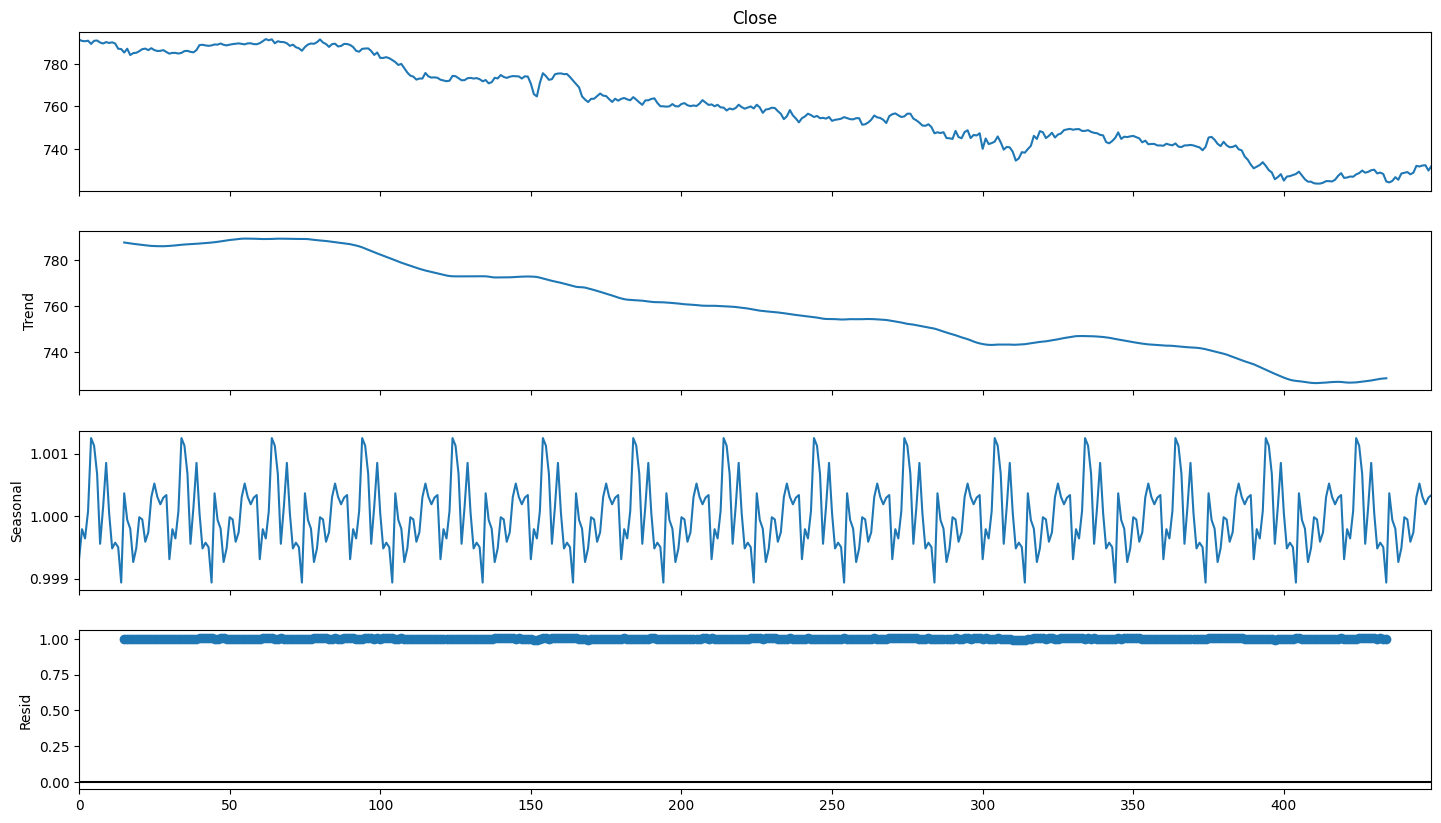

In [5]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


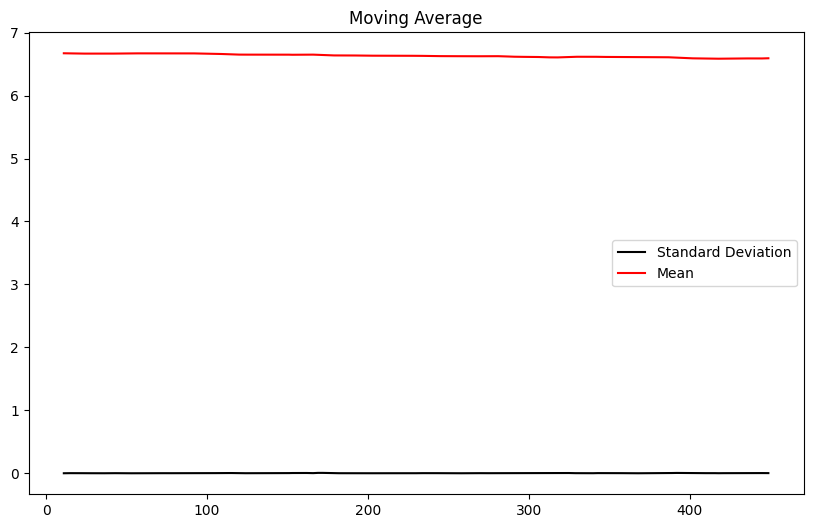

In [6]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

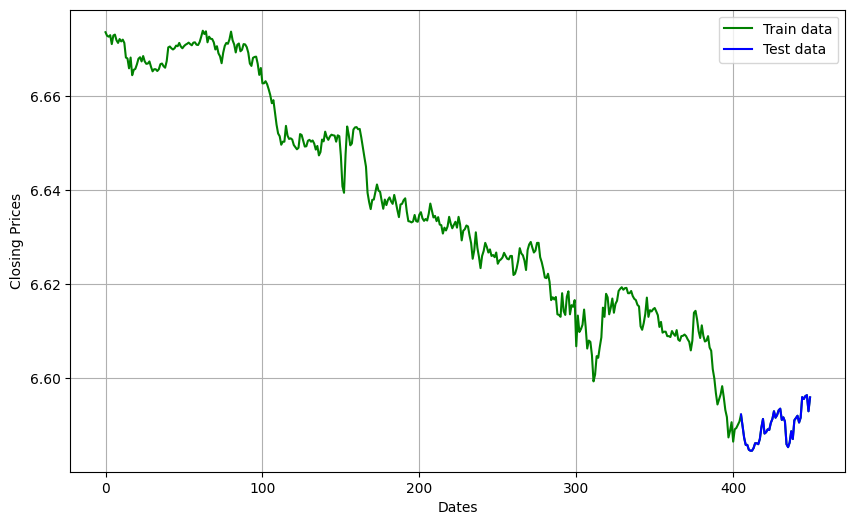

In [7]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3875.117, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3873.599, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3873.704, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3872.575, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3871.109, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.189 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  402
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1939.558
Date:                Wed, 27 Mar 2024   AIC                          -3875.117
Time:                        14:20:08   BIC                          -3867.129
Sample:                             0   HQIC                         -3871.954
                                - 402                                  

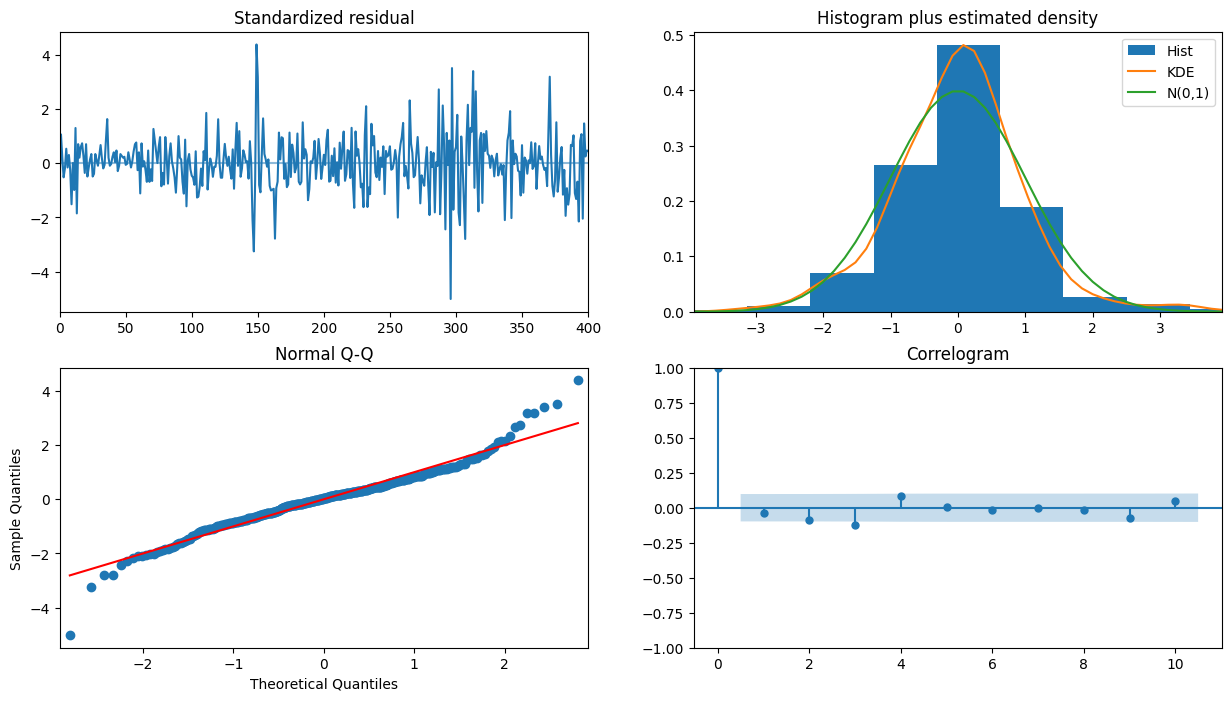

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [10]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  402
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1938.470
Date:                Wed, 27 Mar 2024   AIC                          -3868.940
Time:                        14:23:41   BIC                          -3852.964
Sample:                             0   HQIC                         -3862.614
                                - 402                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0294      0.660     -0.045      0.964      -1.323       1.264
ma.L1          0.0068      0.662      0.010      0.992      -1.291       1.304
ma.L2         -0.0713      0.043     -1.662      0.0